# Stability of Planetary Orbital Configurations Klassifier

The SPOCK package combines several different estimators for the stability of compact planetary configurations. 
When possible, we make them all use the same API so that they can be easily compared to one another and to N-body integrations.

# Input Format

The input is simply a full set of initial conditions including masses, positions and velocities for the star and all the planets. 
A useful way to think about it is that it's all the same information you'd have to put in to run an N-body integration. 
We therefore choose to format the input for all the SPOCK package estimators as a `Simulation` object from the REBOUND N-body package (https://github.com/hannorein/rebound). 

This gives you both a useful set of methods for specifying initial conditions (see https://github.com/hannorein/rebound/blob/master/ipython_examples/OrbitalElements.ipynb for details), and the option to visualize and run additional N-body tests. See https://github.com/hannorein/rebound/blob/master/ipython_examples/Units.ipynb for a discussion of units used in REBOUND.

Let's make a simple compact system with small eccentricities and arbitrary pericenter longitudes and orbital phases:

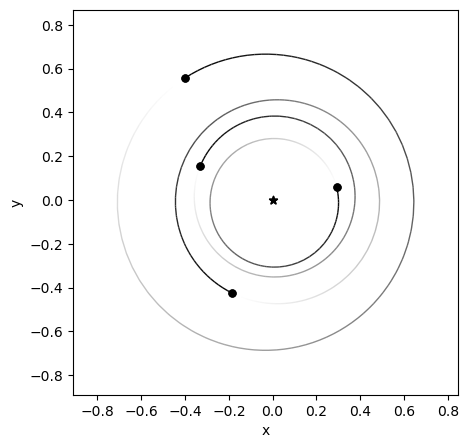

In [1]:
import rebound
%matplotlib inline

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=3.e-5, P=1., e=0.05, pomega = 2.1, l=0.3)
sim.add(m=3.e-5, P=1.4, e=0.05, pomega = 4.2, l=2.8)
sim.add(m=3.e-5, P=2, e=0.05, pomega = 2.8, l=4.2)
sim.add(m=3.e-5, P=3.5, e=0.05, pomega = 0.3, l=2.1)
sim.move_to_com()
fig = rebound.OrbitPlot(sim)

# Predict stability over 1 billion orbits

We first predict the probability the system will survive for a billion orbits using the machine learning classifier from [Tamayo et al., 2020](http://arxiv.org/abs/2007.06521). 

We start by making a `FeatureClassifier` instance.

In [2]:
from spock import FeatureClassifier
model = FeatureClassifier()

[10:51:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


Integrating for a billion orbits numerically would take several hours with direct N-body. The machine learning evaluation takes about half a second

In [3]:
%%time
model.predict_stable(sim)

CPU times: user 611 ms, sys: 195 ms, total: 806 ms
Wall time: 358 ms


0.008615661

# Features

Typically all we want is a probability of stability, but if you are interested you can also explore the short summary features measured in the short integration which we discuss in detail in our paper. There is a separate set of features for each adjacent trio of planets, in the order they were added to the `Simulation` above (first set is for the planets with indices 1,2,3, the second is for indices 2,3,4, and so on).

In [4]:
model.generate_features(sim)

([OrderedDict([('EMcrossnear', 0.2514774632841199),
               ('EMfracstdnear', 0.050747198892617716),
               ('EPstdnear', 0.0125371045437882),
               ('MMRstrengthnear', 0.609862725871568),
               ('EMcrossfar', 0.26844697165875697),
               ('EMfracstdfar', 0.08025175275345586),
               ('EPstdfar', 0.013481778236205413),
               ('MMRstrengthfar', 0.015537017584178569),
               ('MEGNO', 6.129018954007963),
               ('MEGNOstd', 1.5626539543066962)]),
  OrderedDict([('EMcrossnear', 0.26844697165875697),
               ('EMfracstdnear', 0.08025175275345586),
               ('EPstdnear', 0.013481778236205413),
               ('MMRstrengthnear', 0.015537017584178569),
               ('EMcrossfar', 0.4522109539032094),
               ('EMfracstdfar', 0.055607895744957586),
               ('EPstdfar', 0.008676383142065626),
               ('MMRstrengthfar', nan),
               ('MEGNO', 6.129018954007963),
               ('

# Predicting the instability time

We might also be interested not just in whether or not the system will survive, but how long it will take an unstable system to undergo an instability. For that we can use the deep learning model of [Cranmer et al., 2021](https://arxiv.org/abs/2101.04117)

In [5]:
from spock import DeepRegressor
deepmodel = DeepRegressor()

Because the dynamics are chaotic, there isn't a single answer to how long a system will take to go unstable [Hussain & Tamayo 2020](https://arxiv.org/abs/2001.04606).
The model of [Cranmer et al., 2021](https://arxiv.org/abs/2101.04117) therefore estimates a distribution of possible instability times, and returns samples from that estimated distribution.

In [6]:
%%time
median, lower, upper, samples = deepmodel.predict_instability_time(sim, return_samples=True)

CPU times: user 5.56 s, sys: 21.1 s, total: 26.7 s
Wall time: 5.71 s


We can plot the distribution of estimated instability times

Text(0.5, 0, 'Instability time (log10(T))')

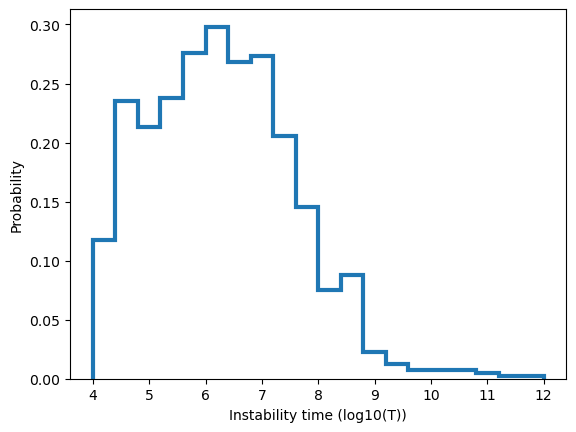

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig, ax = plt.subplots()
ax.hist(np.log10(samples), density=True,
            histtype=u'step', bins=20,
            range=(4, 12), lw=3);

plt.ylabel('Probability')
plt.xlabel('Instability time (log10(T))')

We can also examine the median instability time, as well as the 16th percentile "lower" boundary, and 84th percentil "upper" boundary:

In [8]:
print("Median instability time = {0:.3e} orbits\n16th percentile instability time = {1:.3e} orbits\n84th percentile instability time = {2:.3e} orbits".format(median, lower, upper))

Median instability time = 1.617e+06 orbits
16th percentile instability time = 7.393e+04 orbits
84th percentile instability time = 3.411e+07 orbits


# Analytical Chaos Criterion

We can also compare these results against the semi-analytic chaos criterion from [Tamayo et al., 2021](https://arxiv.org/abs/2106.14863).
This is not a one-to-one comparison, but configurations that are chaotic through two-body MMR overlap are generally unstable on long timescales (see paper).

To better match up with the above classifiers, the analytical classifier returns a probability the system is **regular**, i.e., not chaotic.
Thus a value close to zero implies a low probability for regular motion (i.e., that the system chaotic, and thus likely to be unstable on long timescales), while a value close to unity implies confidence the system is regular.
We import and initialize the model analogously:

In [9]:
from spock import AnalyticalClassifier
analyticalmodel = AnalyticalClassifier()

In [10]:
%%time
prob = analyticalmodel.predict_stable(sim)
print("Probability of regular (non-chaotic) motion: {0:.2f}".format(prob))

Probability of regular (non-chaotic) motion: 0.00
CPU times: user 85.8 ms, sys: 8.28 ms, total: 94.1 ms
Wall time: 97.6 ms


Specifically, the model calculates the probability of regular motion as max(1-tau, 0), where tau is the optical depth or covering fraction of 2-body mean motion resonances (MMRs), estimated at their maximum width in the system's secular cycle (see paper).
In this case it returns 0 because the covering fraction of 2-body MMRs exceeds unity.

When this is not the case, the MMRs are not overlapped across the full range of period ratios in the neighborhood of the input configuration.
However, the widths of individual MMRs are still expanding and contracting adiabatically, and can drive chaos depending on the exact period ratios, eccentricities and angles of the system in question.
In this case, our simple estimated probability for regular motion (less than 1) corresponds to the fraction of period ratio space that is not covered by these MMRs (see discussion and figures in the paper)